In [35]:
import re
import pandas as pd
from datetime import datetime

with open('./data/HC-5059_ID06-LVP.txt', 'r') as file:
    data = file.read()
    # log_pattern = r"(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}): (.*?)(?: message=|$)"
    log_pattern = r"(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}): .*?(run\d+_\w+).*? (has been archived|has been sent to archive|has been stored into ICAT successfully)(?:.*?files=(\d+))?(?:.*?size=(\d+) bytes)?"

    parsed_logs = []
    
    for log in data.split('\n'):
        match = re.match(log_pattern, log)
        if match:
            parsed_logs.append({
                'Timestamp': datetime.strptime(match.group(1), '%Y-%m-%d %H:%M:%S'),
                'Dataset': match.group(2),
                'Action': match.group(3),
                'Files': int(match.group(4)) if match.group(4) else None,
                'Size (GB)': round(int(match.group(5)) / 1e+9, 2) if match.group(5) else None
            })

    df_logs = pd.DataFrame(parsed_logs)
df_logs

,Timestamp,Dataset,Action,Files,Size (GB)
0,2023-02-27 12:08:29,run6_Pdown1,has been archived,NaN,NaN
1,2023-02-27 12:05:31,run6_Pdown1,has been stored into ICAT successfully,NaN,NaN
2,2023-02-27 12:05:31,run6_Pdown1,has been sent to archive,2425.0,8.40
3,2023-02-27 11:23:25,run5_Pdown1,has been archived,NaN,NaN
4,2023-02-27 10:48:21,run6_Pup2,has been archived,NaN,NaN
...,...,...,...,...,...
73,2023-02-22 14:39:55,run1_Pup1,has been stored into ICAT successfully,NaN,NaN
74,2023-02-22 14:39:55,run1_Pup1,has been sent to archive,400.0,1.38
75,2023-02-22 12:40:07,run1_noload,has been archived,NaN,NaN
76,2023-02-22 12:35:48,run1_noload,has been sent to archive,240.0,0.83


In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

In [36]:
action_counts = df_logs["Action"].value_counts()

In [37]:
dataset_counts = df_logs["Dataset"].value_counts().head(10)

In [39]:
df_storage = df_logs.dropna(subset=["Size (GB)"])
total_storage = df_storage["Size (GB)"].sum()
average_dataset_size = df_storage["Size (GB)"].mean()

In [40]:
df_logs["Hour"] = df_logs["Timestamp"].dt.hour
hourly_counts = df_logs.groupby("Hour").size()

C:\Users\Dimitry\AppData\Local\Temp\ipykernel_12712\3097023483.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=action_counts.index, y=action_counts.values, palette="Blues")


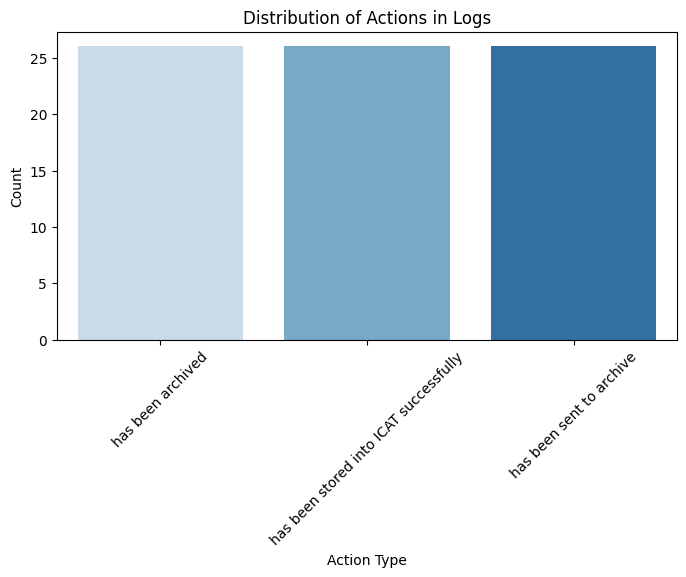

In [41]:
plt.figure(figsize=(8, 4))
sns.barplot(x=action_counts.index, y=action_counts.values, palette="Blues")
plt.title("Distribution of Actions in Logs")
plt.xlabel("Action Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

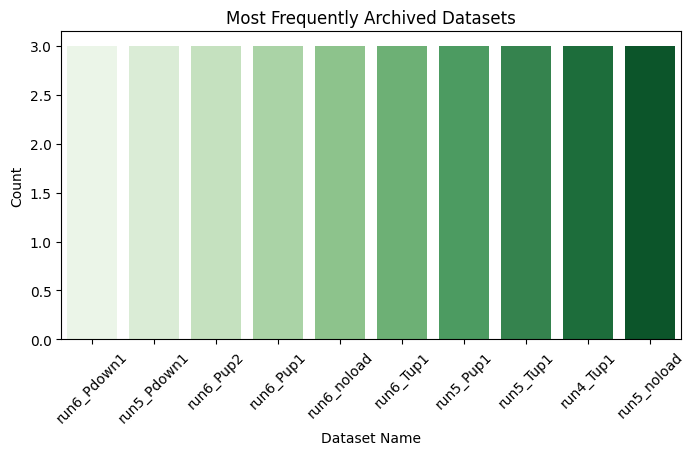

In [57]:
plt.figure(figsize=(8, 4))
sns.barplot(x=dataset_counts.index, y=dataset_counts.values, palette="Greens", hue=dataset_counts.index)
plt.title("Most Frequently Archived Datasets")
plt.xlabel("Dataset Name")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

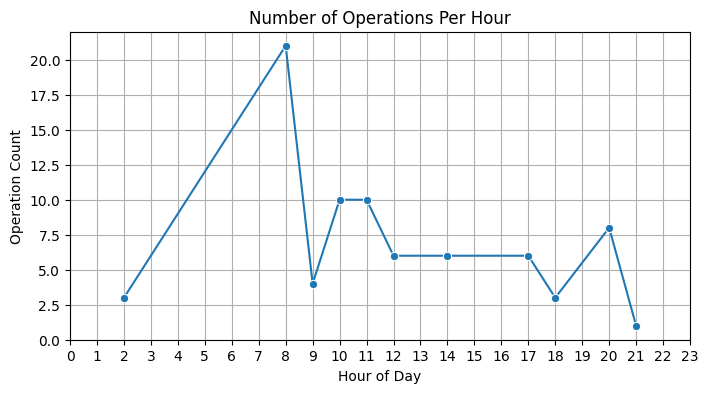

In [43]:
plt.figure(figsize=(8, 4))
sns.lineplot(x=hourly_counts.index, y=hourly_counts.values, marker="o")
plt.title("Number of Operations Per Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Operation Count")
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()

In [56]:
storage_stats = {
    "Total Storage Used (GBytes)": float(total_storage),
    "Average Dataset Size (GBytes)": float(round(average_dataset_size, 2)),
    "Total Dataset Operations": df_logs.shape[0],
    "Most Frequent Dataset": dataset_counts.idxmax()
}

for key, value in storage_stats.items():
    print(f'{key}: {value}')

Total Storage Used (GBytes): 147.3
Average Dataset Size (GBytes): 5.67
Total Dataset Operations: 78
Most Frequent Dataset: run6_Pdown1


In [61]:
df_logs["Date"] = df_logs["Timestamp"].dt.date
daily_counts = df_logs.groupby("Date").size()
daily_storage = df_storage.groupby(df_storage["Timestamp"].dt.date)["Size (GB)"].sum()

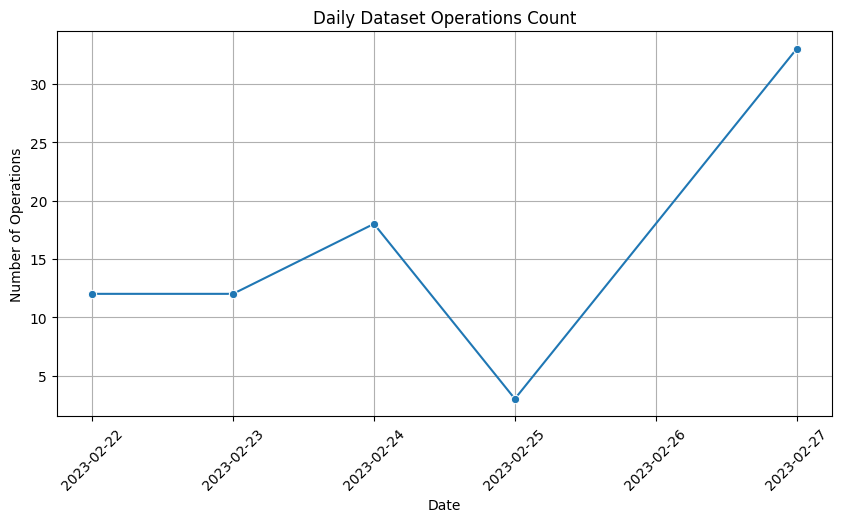

In [62]:
plt.figure(figsize=(10, 5))
sns.lineplot(x=daily_counts.index, y=daily_counts.values, marker="o", linestyle="-")
plt.title("Daily Dataset Operations Count")
plt.xlabel("Date")
plt.ylabel("Number of Operations")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

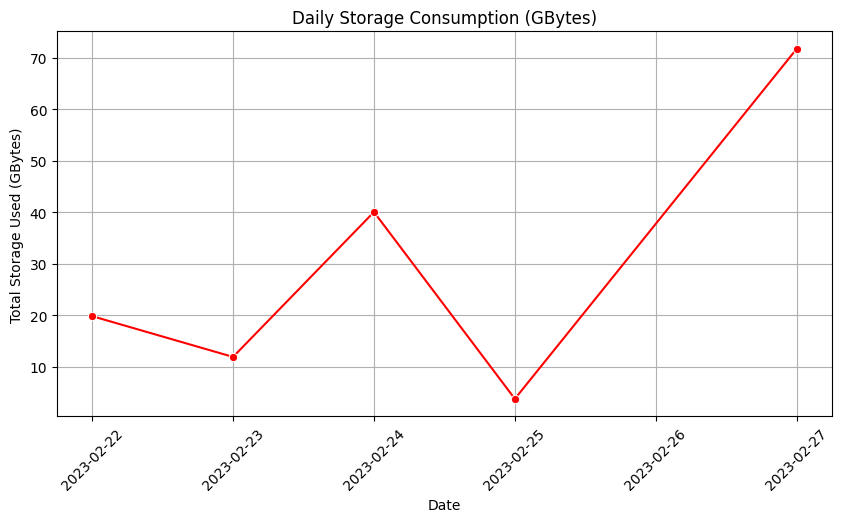

In [66]:
if not daily_storage.empty:
    plt.figure(figsize=(10, 5))
    sns.lineplot(x=daily_storage.index, y=daily_storage.values, marker="o", linestyle="-", color="red")
    plt.title("Daily Storage Consumption (GBytes)")
    plt.xlabel("Date")
    plt.ylabel("Total Storage Used (GBytes)")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

In [64]:
daily_summary = pd.DataFrame({
    "Total Operations": daily_counts,
    "Total Storage Used (Bytes)": daily_storage
}).fillna(0)

In [65]:
daily_summary

,Total Operations,Total Storage Used (Bytes)
2023-02-22,12,19.84
2023-02-23,12,11.93
2023-02-24,18,40.04
2023-02-25,3,3.80
2023-02-27,33,71.69


In [67]:
df_logs = df_logs.sort_values(by="Timestamp")
df_logs["Time Gap (Minutes)"] = df_logs["Timestamp"].diff().dt.total_seconds() / 60

In [68]:
avg_time_gap = df_logs["Time Gap (Minutes)"].mean()
max_time_gap = df_logs["Time Gap (Minutes)"].max()
min_time_gap = df_logs["Time Gap (Minutes)"].min()

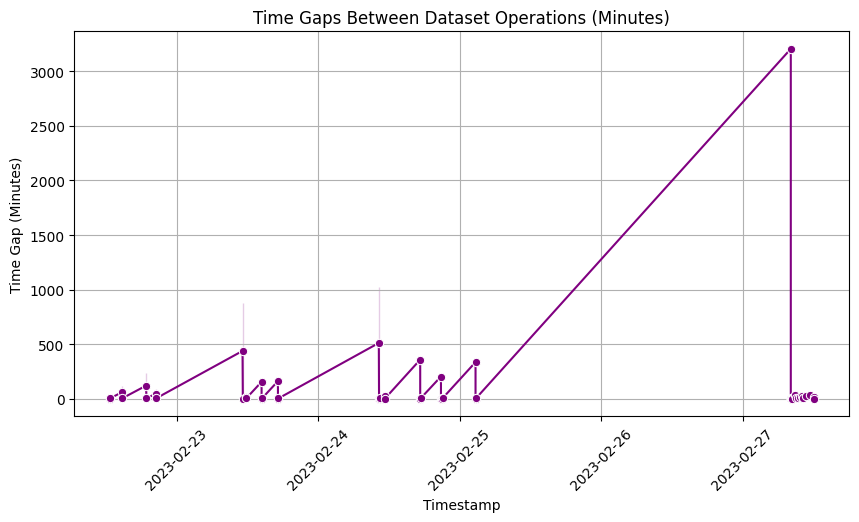

In [69]:
plt.figure(figsize=(10, 5))
sns.lineplot(x=df_logs["Timestamp"], y=df_logs["Time Gap (Minutes)"], marker="o", linestyle="-", color="purple")
plt.title("Time Gaps Between Dataset Operations (Minutes)")
plt.xlabel("Timestamp")
plt.ylabel("Time Gap (Minutes)")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [72]:
time_gap_stats = {
    "Average Time Gap (Minutes)": round(avg_time_gap, 2),
    "Max Time Gap (Minutes)": round(max_time_gap, 2),
    "Min Time Gap (Minutes)": round(min_time_gap,2)
}

for key, value in time_gap_stats.items():
    print(f'{key}: {value}')

Average Time Gap (Minutes): 93.15
Max Time Gap (Minutes): 3205.4
Min Time Gap (Minutes): 0.0


In [74]:
from sklearn.ensemble import IsolationForest

In [75]:
df_logs_clean = df_logs.dropna(subset=["Time Gap (Minutes)"])

In [101]:
iso_forest = IsolationForest(contamination=0.03, random_state=42)
df_logs_clean.loc[:, "Anomaly"] = iso_forest.fit_predict(df_logs_clean[["Time Gap (Minutes)"]])

In [102]:
df_logs_clean.loc[:, "Anomaly"] = df_logs_clean["Anomaly"].map({1: "Normal", -1: "Anomaly"})

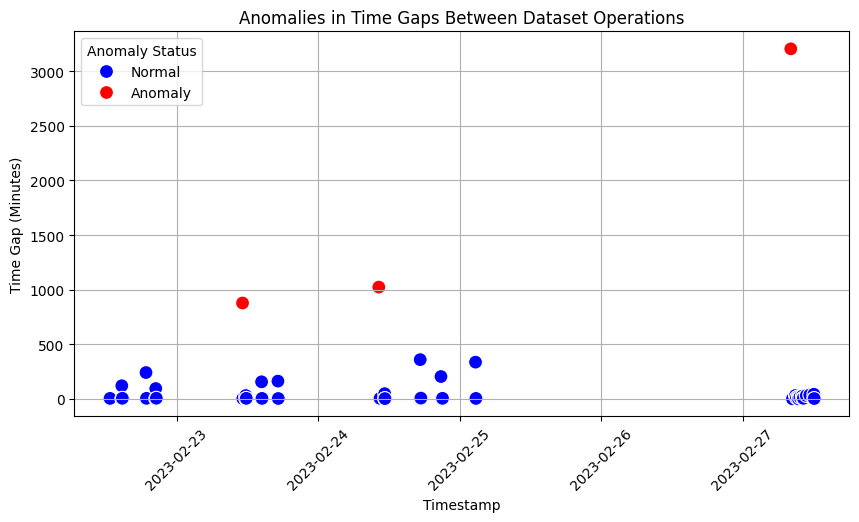

In [103]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x=df_logs_clean["Timestamp"], y=df_logs_clean["Time Gap (Minutes)"], hue=df_logs_clean["Anomaly"], palette={"Normal": "blue", "Anomaly": "red"}, s=100)
plt.title("Anomalies in Time Gaps Between Dataset Operations")
plt.xlabel("Timestamp")
plt.ylabel("Time Gap (Minutes)")
plt.xticks(rotation=45)
plt.legend(title="Anomaly Status")
plt.grid(True)
plt.show()

In [106]:
df_anomalies = df_logs_clean[df_logs_clean["Anomaly"] == "Anomaly"]
df_anomalies.head()

,Timestamp,Dataset,Action,Files,Size (GB),Hour,Date,Time Gap (Minutes),Anomaly
65,2023-02-23 11:08:47,run1_Pdown1,has been stored into ICAT successfully,NaN,NaN,11,2023-02-23,877.683333,Anomaly
53,2023-02-24 10:16:15,run2_Pdown1,has been stored into ICAT successfully,NaN,NaN,10,2023-02-24,1023.533333,Anomaly
32,2023-02-27 08:10:25,run6_Tup2,has been stored into ICAT successfully,NaN,NaN,8,2023-02-27,3205.400000,Anomaly


In [107]:
df_anomalies_storage = df_anomalies.dropna(subset=["Size (GB)"])

In [108]:
storage_comparison = df_logs_clean.groupby("Anomaly")[["Size (GB)", "Files"]].mean()

In [110]:
df_logs_clean.loc[:,"Prev Action"] = df_logs_clean["Action"].shift(1)
df_logs_clean.loc[:, "Prev Dataset"] = df_logs_clean["Dataset"].shift(1)

In [111]:
df_anomaly_context = df_logs_clean[df_logs_clean["Timestamp"].isin(df_anomalies["Timestamp"])]

In [112]:
storage_comparison

,Size (GB),Files
Anomaly,,
Anomaly,NaN,NaN
Normal,5.665385,1636.615385


In [142]:
df_storage_clean = df_logs_clean.dropna(subset=["Size (GB)"])

In [143]:
iso_forest_storage = IsolationForest(contamination=0.04, random_state=42)
df_storage_clean.loc[:, "Storage Anomaly"] = iso_forest_storage.fit_predict(df_storage_clean[["Size (GB)"]])

C:\Users\Dimitry\AppData\Local\Temp\ipykernel_12712\4085489359.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_storage_clean.loc[:, "Storage Anomaly"] = iso_forest_storage.fit_predict(df_storage_clean[["Size (GB)"]])


In [144]:
df_storage_clean.loc[:, "Storage Anomaly"] = df_storage_clean["Storage Anomaly"].map({1: "Normal", -1: "Anomaly"})

C:\Users\Dimitry\AppData\Local\Temp\ipykernel_12712\3834980786.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['Normal' 'Normal' 'Normal' 'Normal' 'Normal' 'Normal' 'Normal' 'Normal'
 'Normal' 'Normal' 'Normal' 'Anomaly' 'Normal' 'Normal' 'Normal' 'Normal'
 'Normal' 'Normal' 'Normal' 'Normal' 'Normal' 'Normal' 'Normal' 'Normal'
 'Normal' 'Normal']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_storage_clean.loc[:, "Storage Anomaly"] = df_storage_clean["Storage Anomaly"].map({1: "Normal", -1: "Anomaly"})


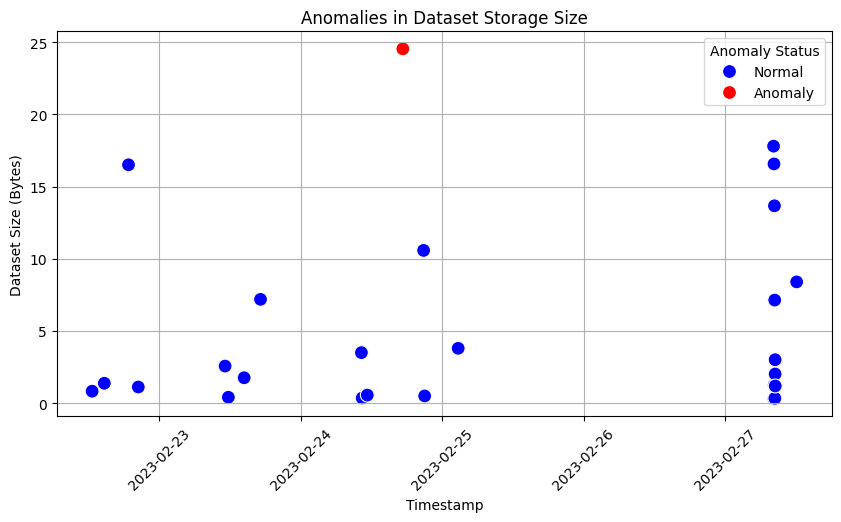

In [145]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x=df_storage_clean["Timestamp"], y=df_storage_clean["Size (GB)"], hue=df_storage_clean["Storage Anomaly"], palette={"Normal": "blue", "Anomaly": "red"}, s=100)
plt.title("Anomalies in Dataset Storage Size")
plt.xlabel("Timestamp")
plt.ylabel("Dataset Size (Bytes)")
plt.xticks(rotation=45)
plt.legend(title="Anomaly Status")
plt.grid(True)
plt.show()

In [146]:
df_storage_anomalies = df_storage_clean[df_storage_clean["Storage Anomaly"] == "Anomaly"]

In [147]:
df_storage_anomalies

,Timestamp,Dataset,Action,Files,Size (GB),Hour,Date,Time Gap (Minutes),Anomaly,Prev Action,Prev Dataset,Storage Anomaly
43,2023-02-24 17:17:42,run3_Tup1,has been sent to archive,7087.0,24.54,17,2023-02-24,0.016667,Normal,has been stored into ICAT successfully,run3_Tup1,Anomaly


In [148]:
df_storage_grouped = df_storage_clean.groupby("Dataset")["Size (GB)"].mean().reset_index()

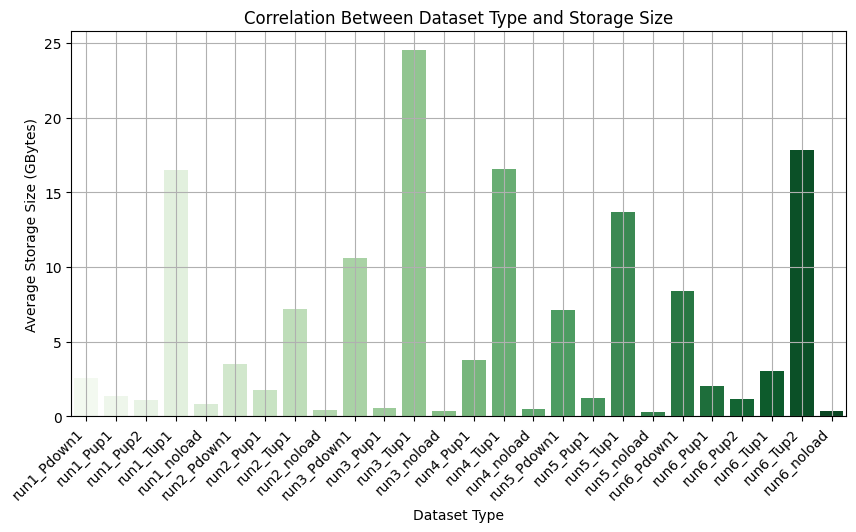

In [153]:
plt.figure(figsize=(10, 5))
sns.barplot(x=df_storage_grouped["Dataset"], y=df_storage_grouped["Size (GB)"], palette="Greens", hue=df_storage_grouped["Dataset"])
plt.title("Correlation Between Dataset Type and Storage Size")
plt.xlabel("Dataset Type")
plt.ylabel("Average Storage Size (GBytes)")
plt.xticks(rotation=45, ha="right")
plt.grid(True)
plt.show()

In [156]:
df_logs_clean.loc[:,"Next Action"] = df_logs_clean["Action"].shift(-1)
df_logs_clean.loc[:,"Next Timestamp"] = df_logs_clean["Timestamp"].shift(-1)
df_logs_clean.loc[:,"Next Dataset"] = df_logs_clean["Dataset"].shift(-1)

In [158]:
df_logs_clean.loc[:, "Storage Time (Minutes)"] = (df_logs_clean["Next Timestamp"] - df_logs_clean["Timestamp"]).dt.total_seconds() / 60

In [159]:
df_storage_efficiency = df_logs_clean[(df_logs_clean["Action"] == "has been sent to archive") & (df_logs_clean["Next Action"] == "has been stored into ICAT successfully")]

In [160]:
avg_storage_time = df_storage_efficiency["Storage Time (Minutes)"].mean()
max_storage_time = df_storage_efficiency["Storage Time (Minutes)"].max()
min_storage_time = df_storage_efficiency["Storage Time (Minutes)"].min()

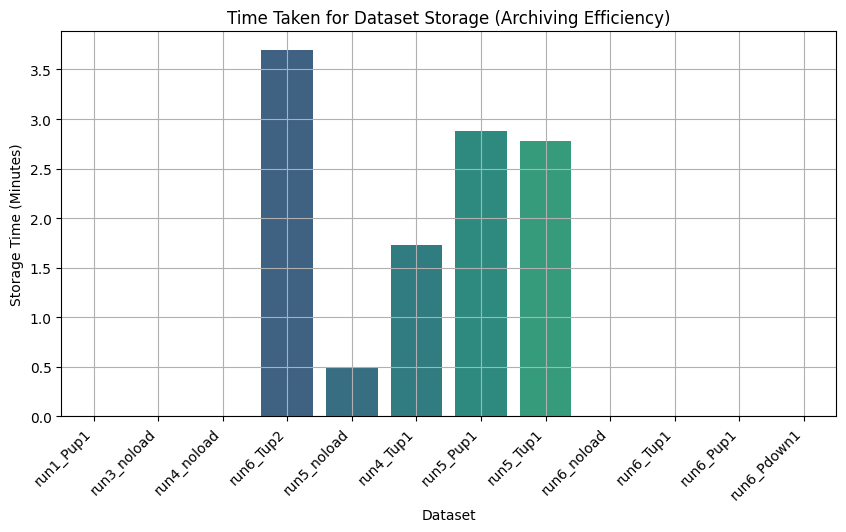

In [162]:
plt.figure(figsize=(10, 5))
sns.barplot(x=df_storage_efficiency["Dataset"], y=df_storage_efficiency["Storage Time (Minutes)"], palette="viridis", hue=df_storage_efficiency["Dataset"])
plt.title("Time Taken for Dataset Storage (Archiving Efficiency)")
plt.xlabel("Dataset")
plt.ylabel("Storage Time (Minutes)")
plt.xticks(rotation=45, ha="right")
plt.grid(True)
plt.show()

In [163]:
storage_efficiency_stats = {
    "Average Storage Time (Minutes)": avg_storage_time,
    "Max Storage Time (Minutes)": max_storage_time,
    "Min Storage Time (Minutes)": min_storage_time
}
for key,value in storage_efficiency_stats.items():
    print(f'{key}: {value}')

Average Storage Time (Minutes): 0.9652777777777777
Max Storage Time (Minutes): 3.7
Min Storage Time (Minutes): 0.0


In [164]:
df_logs_clean.loc[:, "Prev Timestamp"] = df_logs_clean["Timestamp"].shift(1)
df_logs_clean.loc[:, "Prev Dataset"] = df_logs_clean["Dataset"].shift(1)
df_logs_clean.loc[:,"Prev Action"] = df_logs_clean["Action"].shift(1)

C:\Users\Dimitry\AppData\Local\Temp\ipykernel_12712\3264702108.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_logs_clean.loc[:, "Prev Timestamp"] = df_logs_clean["Timestamp"].shift(1)


In [165]:
df_logs_clean.loc[:, "Action Delay (Minutes)"] = (df_logs_clean["Timestamp"] - df_logs_clean["Prev Timestamp"]).dt.total_seconds() / 60

C:\Users\Dimitry\AppData\Local\Temp\ipykernel_12712\2141466062.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_logs_clean.loc[:, "Action Delay (Minutes)"] = (df_logs_clean["Timestamp"] - df_logs_clean["Prev Timestamp"]).dt.total_seconds() / 60


In [166]:
df_action_delays = df_logs_clean[df_logs_clean["Dataset"] == df_logs_clean["Prev Dataset"]]

In [167]:
avg_action_delay = df_action_delays["Action Delay (Minutes)"].mean()
max_action_delay = df_action_delays["Action Delay (Minutes)"].max()
min_action_delay = df_action_delays["Action Delay (Minutes)"].min()

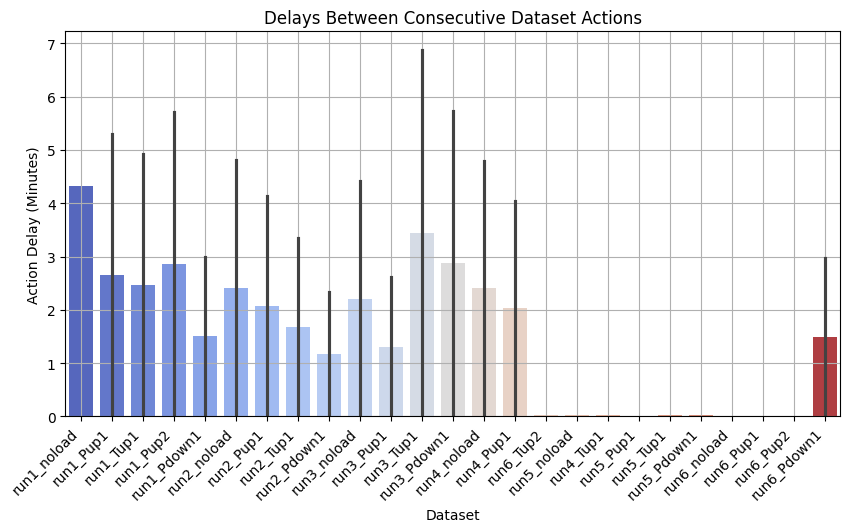

In [169]:
plt.figure(figsize=(10, 5))
sns.barplot(x=df_action_delays["Dataset"], y=df_action_delays["Action Delay (Minutes)"], palette="coolwarm", hue=df_action_delays["Dataset"])
plt.title("Delays Between Consecutive Dataset Actions")
plt.xlabel("Dataset")
plt.ylabel("Action Delay (Minutes)")
plt.xticks(rotation=45, ha="right")
plt.grid(True)
plt.show()

In [170]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

In [171]:
log_messages = df_logs_clean["Action"].astype(str) + " - " + df_logs_clean["Dataset"].astype(str)

In [172]:
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(log_messages)

In [173]:
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
df_logs_clean["Cluster"] = kmeans.fit_predict(X_tfidf)

c:\Users\Dimitry\miniconda3\envs\practice\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Dimitry\miniconda3\envs\practice\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "c:\Users\Dimitry\miniconda3\envs\practice\lib\subprocess.py", line 503, in run
    with Popen(*popenargs, **kwargs) as process:
  File "c:\Users\Dimitry\miniconda3\envs\practice\lib\subprocess.py", line 971, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\Dimitry\miniconda3\envs\practice\lib\subprocess.py", line 1456, in _execute_child
    hp, ht, pid, tid = _

C:\Users\Dimitry\AppData\Local\Temp\ipykernel_12712\3521831135.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df_logs_clean["Cluster"], palette="Set2")


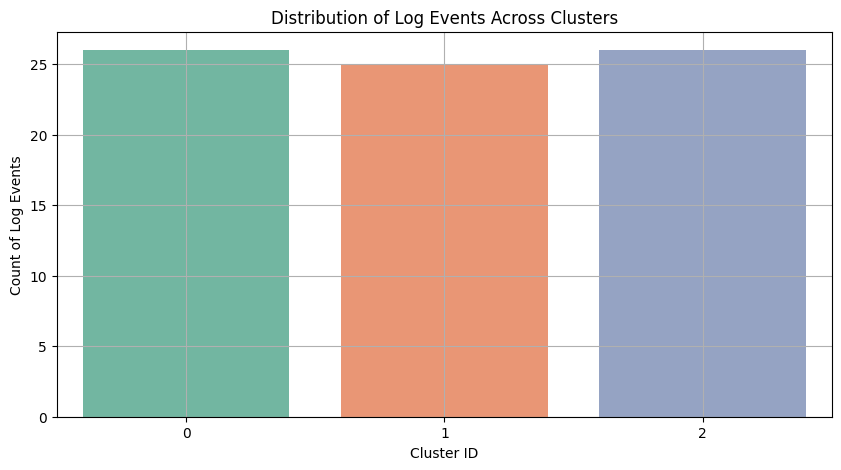

In [174]:
plt.figure(figsize=(10, 5))
sns.countplot(x=df_logs_clean["Cluster"], palette="Set2")
plt.title("Distribution of Log Events Across Clusters")
plt.xlabel("Cluster ID")
plt.ylabel("Count of Log Events")
plt.grid(True)
plt.show()

In [175]:
cluster_analysis = df_logs_clean.groupby("Cluster")["Action"].value_counts().unstack().fillna(0)

<Figure size 1200x600 with 0 Axes>

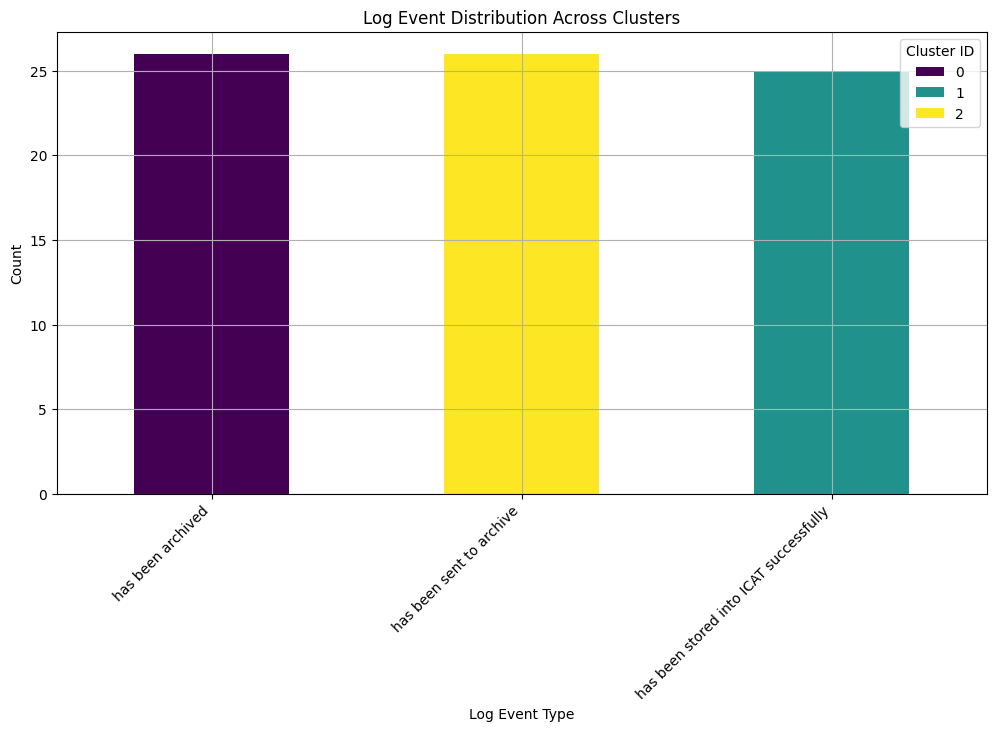

In [176]:
plt.figure(figsize=(12, 6))
cluster_analysis.T.plot(kind="bar", figsize=(12, 6), colormap="viridis", stacked=True)
plt.title("Log Event Distribution Across Clusters")
plt.xlabel("Log Event Type")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Cluster ID")
plt.grid(True)
plt.show()

In [177]:
cluster_summary = df_logs_clean.groupby("Cluster").agg(
    total_events=("Action", "count"),
    unique_datasets=("Dataset", "nunique"),
    min_timestamp=("Timestamp", "min"),
    max_timestamp=("Timestamp", "max")
)

In [178]:
cluster_summary

,total_events,unique_datasets,min_timestamp,max_timestamp
Cluster,,,,
0,26,26,2023-02-22 12:40:07,2023-02-27 12:08:29
1,25,25,2023-02-22 14:39:55,2023-02-27 12:05:31
2,26,26,2023-02-22 12:35:48,2023-02-27 12:05:31


In [179]:
from sklearn.decomposition import PCA

In [180]:
df_logs_clean["Hour"] = df_logs_clean["Timestamp"].dt.hour

C:\Users\Dimitry\AppData\Local\Temp\ipykernel_12712\3186694390.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_logs_clean["Hour"] = df_logs_clean["Timestamp"].dt.hour


In [181]:
dataset_mapping = {name: idx for idx, name in enumerate(df_logs_clean["Dataset"].unique())}

In [182]:
df_logs_clean["Dataset_Num"] = df_logs_clean["Dataset"].map(dataset_mapping)

C:\Users\Dimitry\AppData\Local\Temp\ipykernel_12712\3278827634.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_logs_clean["Dataset_Num"] = df_logs_clean["Dataset"].map(dataset_mapping)


In [183]:
X_enhanced = pd.DataFrame({
    "Hour": df_logs_clean["Hour"],
    "Dataset_Num": df_logs_clean["Dataset_Num"]
})

In [184]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_enhanced)

In [185]:
num_clusters = 3
kmeans_enhanced = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
df_logs_clean["Enhanced Cluster"] = kmeans_enhanced.fit_predict(X_pca)

C:\Users\Dimitry\AppData\Local\Temp\ipykernel_12712\4212928796.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_logs_clean["Enhanced Cluster"] = kmeans_enhanced.fit_predict(X_pca)


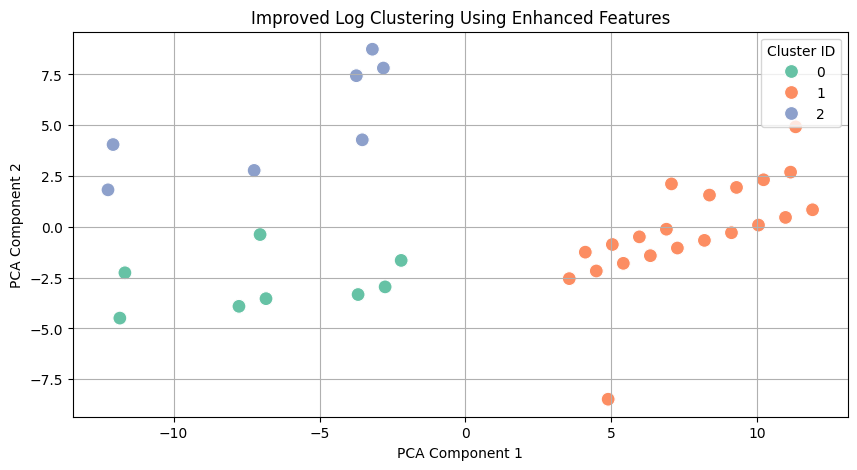

In [186]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df_logs_clean["Enhanced Cluster"], palette="Set2", s=100)
plt.title("Improved Log Clustering Using Enhanced Features")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster ID")
plt.grid(True)
plt.show()

In [188]:
enhanced_cluster_analysis = df_logs_clean.groupby("Enhanced Cluster")["Action"].value_counts().unstack().fillna(0)

<Figure size 1200x600 with 0 Axes>

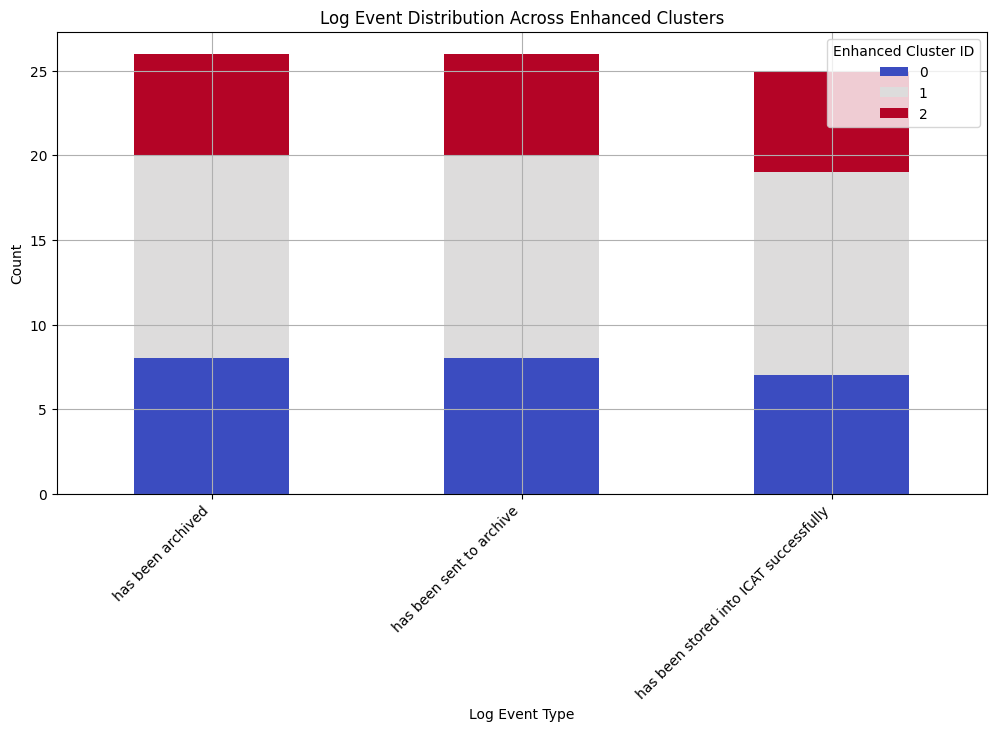

In [189]:
plt.figure(figsize=(12, 6))
enhanced_cluster_analysis.T.plot(kind="bar", figsize=(12, 6), colormap="coolwarm", stacked=True)
plt.title("Log Event Distribution Across Enhanced Clusters")
plt.xlabel("Log Event Type")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Enhanced Cluster ID")
plt.grid(True)
plt.show()

In [191]:
enhanced_cluster_summary = df_logs_clean.groupby("Enhanced Cluster").agg(
    total_events=("Action", "count"),
    unique_datasets=("Dataset", "nunique"),
    min_timestamp=("Timestamp", "min"),
    max_timestamp=("Timestamp", "max"),
    avg_hour=("Hour", "mean")
)
enhanced_cluster_summary

,total_events,unique_datasets,min_timestamp,max_timestamp,avg_hour
Enhanced Cluster,,,,,
0,23,8,2023-02-22 12:35:48,2023-02-24 11:18:38,11.608696
1,36,12,2023-02-25 02:40:57,2023-02-27 12:08:29,8.250000
2,18,6,2023-02-22 18:46:06,2023-02-24 21:04:45,18.722222


In [193]:
import networkx as nx

In [196]:
df_logs_clean.loc[:, "Next Cluster"] = df_logs_clean["Enhanced Cluster"].shift(-1)
df_logs_clean.loc[:,"Next Timestamp"] = df_logs_clean["Timestamp"].shift(-1)

In [197]:
df_transitions = df_logs_clean.dropna(subset=["Next Cluster"])

In [198]:
transition_counts = df_transitions.groupby(["Enhanced Cluster", "Next Cluster"]).size().unstack().fillna(0)

In [200]:
G = nx.DiGraph()
for cluster in df_logs_clean["Enhanced Cluster"].unique():
    G.add_node(cluster)

In [201]:
for (start, end), count in transition_counts.stack().items():
    if count > 0:
        G.add_edge(start, end, weight=count)

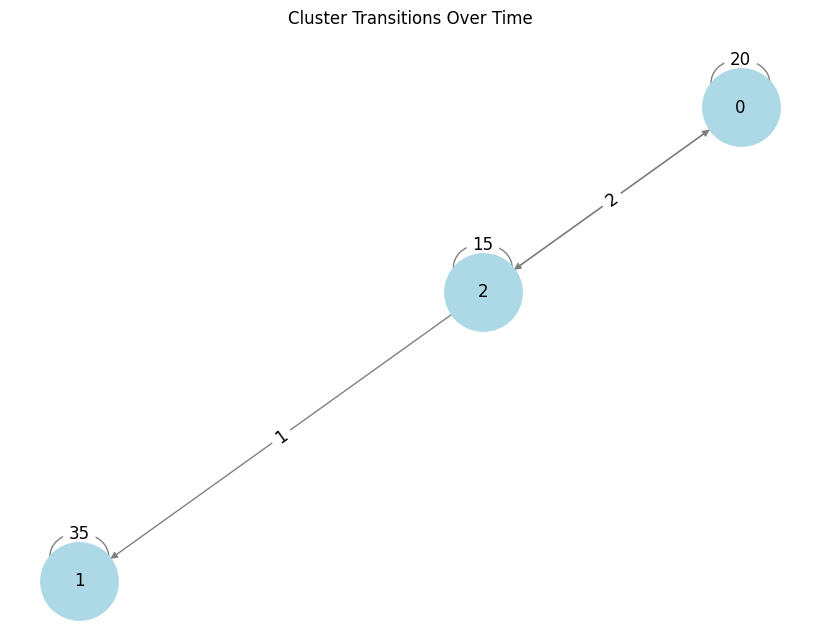

In [202]:
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G, seed=42)  # Positioning of nodes
nx.draw(G, pos, with_labels=True, node_size=3000, node_color="lightblue", edge_color="gray", linewidths=2, font_size=12)
edge_labels = {(i, j): f"{int(w)}" for i, j, w in G.edges(data="weight")}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=12)
plt.title("Cluster Transitions Over Time")
plt.show()